## To do list:

## Model instability has been fixed (the unique depths needed to be sorted)

## Possible ways to improve model performance

* Add atmospheric CO2
* Apply your better spike removal code to the other sites
* Try the interpolated precip from PRISM
* Try random forest model
* Interpolate missing CO2 and soil moisture (try single site interpolation)
* Try neural net model
* Use latitude instead of site number
* Add elevation
* Add land cover type (maybe we should try biomass carbon density maps instead)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive 
# list of all potential features across all pits
features = ['CO2', 'timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 
            'WaterPotential', 'ReductionPotential', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude']
m = len(features)

# Define site and pit number indices
site_nos = {'Calhoun': 0, 'Shale_Hills': 2, 
            'Catalina-Jemez': 1, 'Seca_Floresta': 3}
pit_nos = {}
i = 0
for site, pits in all_pits.items():
    for pit in pits:
        pit_nos[pit] = i
        i += 1
        
# Remove pits with manual samples
del all_pits['Seca_Floresta']
all_pits['Calhoun'].remove('R1C2')
all_pits['Shale_Hills'].remove('SPMS')
all_pits['Shale_Hills'].remove('NPMS')
all_pits['Shale_Hills'].remove('TMMS')
all_pits['Shale_Hills'].remove('LRMS')
all_pits['Shale_Hills'].remove('SPVF')


In [2]:
total_count = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        with open(infile) as f:
            for i, l in enumerate(f):
                pass
        nlines = i + 1
        total_count += nlines
        print(site, pit, '--', nlines)
print(total_count)

Calhoun R1C1 -- 28388
Calhoun R1H1 -- 28394
Calhoun R1P1 -- 28393
Catalina-Jemez BGZOB1 -- 27277
Catalina-Jemez BGZOB2 -- 27302
Catalina-Jemez BGZOB3 -- 27297
Catalina-Jemez BGZOB4 -- 27275
Catalina-Jemez Green1 -- 27976
Catalina-Jemez Green2 -- 6995
Catalina-Jemez Green3 -- 27975
Catalina-Jemez MC1 -- 72374
Catalina-Jemez MC2 -- 72658
Catalina-Jemez MC3 -- 72539
Catalina-Jemez MC4 -- 72540
Catalina-Jemez MC5 -- 71698
Catalina-Jemez MC6 -- 72539
691620


In [3]:
# Load in and merge all files
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        df = pd.read_csv(infile, parse_dates=[0], na_values=[-99999])

        # Remove records without any CO2 data
        co2_cols = [col for col in df.columns if 'CO2' in col]
        df = df[~df.loc[:, co2_cols].isna().all(axis=1)]
        
        depths = []
        for col in df.columns:
            if ('precip' not in col) and ('DateTime' not in col) and ('latitude' not in col) and ('elevation' not in col):
                depths.append(col.split('_')[1].split('cm')[0])
        unique_depths = list(set(depths))
        unique_depths.sort()
        
        # t is the number of time steps
        t = df.shape[0]

        # data shape is the # of observations (# time points * depths), # features
        cur_data = np.empty((t*len(unique_depths), m))
        cur_data[:] = np.nan
        

        for i, depth in enumerate(unique_depths):
            
            depth_cols = [col for col in df.columns if '_%scm' % depth in col]
            for j, feature in enumerate(features):
                #print (df[col[0]])
                #cur_data[i*t:(i+1)*t, 13]=df.latitude
                # Look for columns with this feature and depth in the name
                if feature == 'precip':
                    col = 'PRISM_precip.mm'
                    
                elif feature == 'timestamp':
                    col = [col for col in df.columns if 'DateTime' in col]
                    col = col[0]
                elif feature == 'latitude':
                    col = 'latitude'
                elif feature == 'elevation':
                    col='elevation'
                elif feature == 'Season':
                    col = [col for col in df.columns if 'DateTime' in col]
                    df['quarter'] = df[col[0]].dt.quarter
                    col = 'quarter'
                else:
                    matches = [col for col in depth_cols if feature in col]
                    

                    # Correct for fact that "O2" search returns "CO2" as well
                    if feature == 'O2':
                        matches = [col for col in matches if 'CO2' not in col]
             

                    if len(matches) > 1:
                        raise ValueError("""More than one possible match found for 
                        %s %s %scm %s""" %(site, pit, depth, feature))
                    elif len(matches) == 1:
                        col = matches[0]
                    else:
                        col = ""
                        continue
                        
    
                # Now that we have the column name, add this subset to cur_data
                
                #latitude_1=df.latitude.to_numpy()
                #latitude_2=df.latitude.to_numpy()
                #latitude=np.append(latitude_1, latitude_2)
                #if j<13:
                cur_data[i*t:(i+1)*t, j] = df[col].values
            
                
                #elif j==14:
                    #cur_data[i*t:(i+1)*t,13] = df[col].values
                    
                #cur_data[:,13]=df.latitude
                
                #cur_data[:,14]=df.elevation
                

            # Add in depth
            cur_data[i*t:(i+1)*t, features.index('Depth')] = depth
            
        # Add in pit and site indices
        cur_data[:, features.index('Pit')] = pit_nos[pit]
        cur_data[:, features.index('Site')] = site_nos[site]
        #cur_data[:, 14] = latitude
        #s=df.latitude
        #s.index+=6793
        
        #latitude=np.reshape (latitude, (1,13586))
        #cur_data[:, features.index('latitude')] = latitude_1
        
        # Copy current data to dict of all data
        data[pit] = cur_data.copy()

In [4]:
df['latitude']

25107    35.883
25108    35.883
25109    35.883
25110    35.883
25111    35.883
          ...  
63773    35.883
63774    35.883
63775    35.883
63776    35.883
63777    35.883
Name: latitude, Length: 35964, dtype: float64

In [5]:
# Merge all data into a single numpy array
for i, (pit, array) in enumerate(data.items()):
    if i == 0:
        merged = array.copy()
    else:
        merged = np.append(merged, array, axis=0)

# Remove rows without any CO2 data
all_rows, _ = merged.shape
merged = merged[~np.isnan(merged[:, 0]), :]
trimmed = all_rows - merged.shape[0]
print(f'Removed {trimmed:,} rows without CO2 data')

df = pd.DataFrame(data=merged, columns=features)


Removed 114,525 rows without CO2 data


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [7]:
#For the nearest neighbors model, run this cell and all subsequent cells

df.drop(columns=['WaterPotential', 'ReductionPotential'], 
        inplace=True)

df.dropna(inplace=True)
#df.reset_index(drop=True, inplace=True)
df

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season,elevation,latitude
6794,13570.0000,1.459382e+18,0.0,0.358000,0.044000,16.705000,19.413019,0.0,50.0,0.0,1.0,184.0,34.61014
6795,13830.0000,1.459386e+18,0.0,0.358000,0.044000,16.770000,19.417373,0.0,50.0,0.0,1.0,184.0,34.61014
6796,14100.0000,1.459390e+18,0.0,0.358000,0.044000,16.835000,19.421726,0.0,50.0,0.0,1.0,184.0,34.61014
6797,14315.0000,1.459393e+18,0.0,0.358000,0.044000,16.890000,19.425410,0.0,50.0,0.0,1.0,184.0,34.61014
6798,14515.0000,1.459397e+18,0.0,0.358000,0.044000,16.940000,19.428758,0.0,50.0,0.0,1.0,184.0,34.61014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357320,17283.8575,1.378375e+18,0.0,0.206000,0.118333,14.052648,19.242505,16.0,60.0,1.0,3.0,3019.0,35.88300
1357321,17157.5350,1.378379e+18,0.0,0.205333,0.116667,14.057570,19.195345,16.0,60.0,1.0,3.0,3019.0,35.88300
1357322,17048.8825,1.378382e+18,0.0,0.205500,0.115000,14.036808,19.112428,16.0,60.0,1.0,3.0,3019.0,35.88300
1357323,16947.1550,1.378386e+18,0.0,0.201400,0.116667,14.015850,18.981997,16.0,60.0,1.0,3.0,3019.0,35.88300


In [8]:
#Check if you have a GPU available for tensorflow
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [181]:
#Model Comparison code starts below
#df_nan=df.copy(deep=True)

#df[(df.Pit==8) & (df.Depth==60)]
#df_loc=df_nan.CO2.loc[((df.Pit==i)&(df.Depth==j))]

3717.6808216867444


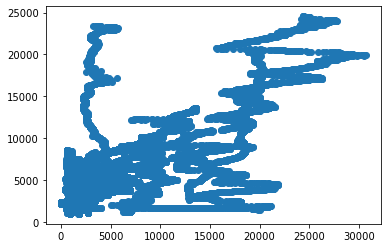

In [9]:
#Run this for systematically missing values
from sklearn import metrics

df_nan=df.copy(deep=True)
df_nan.CO2.loc[df.groupby(['Pit','Depth']).tail(2000).index]=np.nan


#df_nan.SoilMoisture.loc[df_nan.sample(frac=0.5).index] = np.nan



nan_index=df_nan[df_nan.CO2.notna()==False]
not_nan_index=df_nan[df_nan.CO2.notna()==True]


df_nan_linear=df_nan.copy(deep=True)
df_nan_median=df_nan.copy(deep=True)

df_nan_median.CO2=df_nan_median.CO2.fillna(np.nanmedian(df_nan_median.CO2))


df_nan_linear.CO2=df_nan_linear.CO2.interpolate()

#df_nan_linear.CO2=df_nan_linear.CO2.fillna(np.nanmedian(df_nan_linear.CO2))


print(metrics.mean_squared_error(df_nan_linear.CO2.loc[nan_index.index], df.CO2.loc[nan_index.index], squared=False))
plt.scatter(df.CO2.loc[nan_index.index], df_nan_linear.CO2.loc[nan_index.index])


In [213]:
df1 =  StandardScaler().fit_transform(df.loc[nan_index.index]) 

df2=pd.DataFrame(data=df1, index=nan_index.index)
df2.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude']
X2=df2[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth',  'Site']]
y2=df2['CO2']  # Labels\n",

In [277]:


#This is an old dense network that is just here for inspiration and to remember commands
df_st =  StandardScaler().fit_transform(df_nan.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
#X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth']]  # Features\n",

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude', ]
X=df_st1[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth', 'Site']]
y=df_st1['CO2']  # Labels\n",

#X_or=df[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth', 'Site']].loc[not_nan_index.index]
#y_or=df['CO2'].loc[not_nan_index.index] 

from tensorflow import random
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

X_reshape = np.reshape(X.values, (X.values.shape[0], X.values.shape[1], 1))
X_or_reshape = np.reshape(X_or.values, (X_or.values.shape[0], X_or.values.shape[1], 1))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
regressor=Sequential([Dense(units=512, input_shape = (X.values.shape[1], ), activation='selu', kernel_initializer='lecun_normal'),
                      Dense(units=256, activation='selu', kernel_initializer='lecun_normal'),
                      #Dense(units=10, activation='relu', kernel_initializer='he_normal'),
                      #Dense(units=15, activation='relu', kernel_initializer='he_normal'),
                      #Dense(units=15, activation='relu', kernel_initializer='he_normal'),
                      #Dense(units=15, activation='relu', kernel_initializer='he_normal'),
                      #Dense(units=15, activation='relu', kernel_initializer='he_normal'),
                      #Dense(units=15, activation='relu', kernel_initializer='he_normal'), Dropout(.1),
                      Dense(units=128, activation='selu', kernel_initializer='lecun_normal'),
                      #Dense(units=5, activation='selu', kernel_initializer='lecun_normal'),
                     # Dense(units=10, activation='selu', kernel_initializer='lecun_normal'),
                      #Dense(units=5, activation='selu', kernel_initializer='lecun_normal'), #Dropout(.1),
                      #Dense(units=1000, activation='selu'),Dense(units=1000, activation='selu'), #Dropout(.2),
                      #Dense(units=1000, activation='selu'),Dense(units=1000, activation='selu'),
                      #Dense(units=64, activation='selu', kernel_initializer='lecun_normal'),Dense(units=64, activation='selu', kernel_initializer='lecun_normal'),
                      Dense(units=64, activation='selu', kernel_initializer='lecun_normal'),Dense(units=32, activation='selu', kernel_initializer='lecun_normal'),
                      #Dense(units=10, activation='selu'), Dense(units=10, activation='selu'),
                      #Dense(units=64, activation='relu'), Dense(units=64, activation='relu' ),
                      Dense(units=1)])
#regressor = Sequential()

#regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (Xtrain_reshape.shape[1], 1), recurrent_dropout=.1))


#param_grid = dict(batch_size=[1000,10000], )
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(X, Y)
opt=tf.keras.optimizers.SGD(learning_rate=0.001)#, beta_1=.9, beta_2=.999)


regressor.compile(optimizer = opt, loss = 'mean_squared_error', loss_weights=1)

regressor.fit(X.values, y.values, epochs = 200, batch_size = 60000,validation_data=(X2, y2))

Epoch 1/200
13/13 [==============================] - 1s 22ms/step - loss: 1.0947 - val_loss: 0.8417
Epoch 2/200
13/13 [==============================] - 0s 16ms/step - loss: 0.7030 - val_loss: 0.7943
Epoch 3/200
13/13 [==============================] - 0s 16ms/step - loss: 0.6601 - val_loss: 0.7670
Epoch 4/200
13/13 [==============================] - 0s 17ms/step - loss: 0.6280 - val_loss: 0.7419
Epoch 5/200
13/13 [==============================] - 0s 20ms/step - loss: 0.6025 - val_loss: 0.7196
Epoch 6/200
13/13 [==============================] - 0s 17ms/step - loss: 0.5816 - val_loss: 0.7052
Epoch 7/200
13/13 [==============================] - 0s 16ms/step - loss: 0.5638 - val_loss: 0.6873
Epoch 8/200
13/13 [==============================] - 0s 16ms/step - loss: 0.5484 - val_loss: 0.6751
Epoch 9/200
13/13 [==============================] - 0s 16ms/step - loss: 0.5347 - val_loss: 0.6634
Epoch 10/200
13/13 [==============================] - 0s 16ms/step - loss: 0.5223 - val_loss: 0.6572

KeyboardInterrupt: 

In [76]:
#Run this cell to reshape the data for LSTM

df_st =  StandardScaler().fit_transform(df_nan.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude', ]
X=df_st1[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth', 'Site', 'elevation', 'latitude']]
y=df_st1['CO2']  # Labels\n",

df1 =  StandardScaler().fit_transform(df.loc[nan_index.index]) 

df2=pd.DataFrame(data=df1, index=nan_index.index)
df2.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude']
X2=df2[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth',  'Site', 'elevation', 'latitude']]
y2=df2['CO2']  # Labels\n",




def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 5
x10,y10=create_dataset(X.values,y,TIME_STEPS)
x20,y20=create_dataset(X2.values,y2.values,TIME_STEPS)
x30,y30=create_dataset(X_nan.values,y_nan.values,TIME_STEPS)

In [195]:
#LSTM model. Performance may be slightly better, but it takes so long to train that it is hard to tell how consistent it is.

from sklearn.preprocessing import StandardScaler
df_st =  StandardScaler().fit_transform(df_nan.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude', ]
X=df_st1[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth', 'Site', 'elevation', 'latitude']]
y=df_st1['CO2']  # Labels\n",

df1 =  StandardScaler().fit_transform(df.loc[nan_index.index]) 

df2=pd.DataFrame(data=df1, index=nan_index.index)
df2.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude']
X2=df2[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth',  'Site', 'elevation', 'latitude']]
y2=df2['CO2']  # Labels\n",

def build_model(n_hidden=6, n_neurons=24, learning_rate=5e-5, input_shape=(x10.shape[1], x10.shape[2] )):
    model=Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    #model.add(Dropout(.2))
    for layer in range(n_hidden):
        
        model.add(LSTM(n_neurons,  activation='relu', return_sequences=True))
        model.add(BatchNormalization())
        #model.add(LeakyReLU(alpha=.5))
        
        model.add(Dropout(.3))
    
    model.add(LSTM(n_neurons,  activation='relu', return_sequences=False))
    model.add(BatchNormalization())
    #model.add(Dropout(.3))
    model.add(Dense(24, activation='relu'))
    
    model.add(Dense(1))
    
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=.9, nesterov=True, decay=2e-6)
    model.compile(loss='huber', optimizer=optimizer)
    return model

In [196]:


keras_reg=keras.wrappers.scikit_learn.KerasRegressor(build_model)

keras_reg.fit(x10,y10,epochs=800, batch_size=512, validation_data=(x20,y20), callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/800
1476/1476 [==============================] - 290s 193ms/step - loss: 0.4344 - val_loss: 0.3040
Epoch 2/800
1476/1476 [==============================] - 303s 205ms/step - loss: 0.3571 - val_loss: 0.2971
Epoch 3/800
1476/1476 [==============================] - 266s 180ms/step - loss: 0.3445 - val_loss: 0.2939
Epoch 4/800
1476/1476 [==============================] - 285s 193ms/step - loss: 0.3376 - val_loss: 0.2854
Epoch 5/800
1476/1476 [==============================] - 269s 182ms/step - loss: 0.3305 - val_loss: 0.2824
Epoch 6/800
 569/1476 [==========>...................] - ETA: 2:24 - loss: 0.3282

KeyboardInterrupt: 

In [ ]:
keras_reg.fit(x10,y10,epochs=800, batch_size=512, validation_data=(x20,y20), callbacks=[keras.callbacks.EarlyStopping(patience=3)])

In [ ]:
#Current best deep net with dropout and batch normalization

df_st =  StandardScaler().fit_transform(df_nan.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude', ]
X=df_st1[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth', 'Site','elevation', 'latitude']]
y=df_st1['CO2']  # Labels\n",

df1 =  StandardScaler().fit_transform(df.loc[nan_index.index]) 

df2=pd.DataFrame(data=df1, index=nan_index.index)
df2.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude']
X2=df2[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth',  'Site','elevation', 'latitude']]
y2=df2['CO2']  # Labels\n",

def build_model(n_hidden=5, n_neurons=50, learning_rate=2e-5, input_shape=(X.values.shape[1], )):
    model=Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    #model.add(Dropout(.2))
    for layer in range(n_hidden):
        model.add(BatchNormalization())
        model.add(Dense(n_neurons,  activation='relu'))
        #model.add(LeakyReLU(alpha=.5))
        #model.add(BatchNormalization())
        model.add(Dropout(.2))
    #model.add(Dense(n_neurons,  activation='relu'))
    model.add(Dense(1))
    
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=.9, nesterov=True, decay=3e-6)
    model.compile(loss='huber', optimizer=optimizer)
    return model
keras_reg=keras.wrappers.scikit_learn.KerasRegressor(build_model)
keras_reg.fit(X,y,epochs=40, batch_size=64, validation_data=(X2,y2), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/40
11801/11801 [==============================] - 100s 8ms/step - loss: 0.4593 - val_loss: 0.2177
Epoch 2/40
11691/11801 [============================>.] - ETA: 0s - loss: 0.3434

In [234]:
keras_reg.fit(X,y,epochs=50, batch_size=128, validation_data=(X2,y2), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
5901/5901 [==============================] - 58s 10ms/step - loss: 0.4503 - val_loss: 0.2836
Epoch 2/50
5901/5901 [==============================] - 56s 9ms/step - loss: 0.3648 - val_loss: 0.2601
Epoch 3/50
5901/5901 [==============================] - 64s 11ms/step - loss: 0.3348 - val_loss: 0.2426
Epoch 4/50
5901/5901 [==============================] - 62s 10ms/step - loss: 0.3166 - val_loss: 0.2306
Epoch 5/50
5901/5901 [==============================] - 57s 10ms/step - loss: 0.3047 - val_loss: 0.2199
Epoch 6/50
5901/5901 [==============================] - 56s 10ms/step - loss: 0.2951 - val_loss: 0.2154
Epoch 7/50
5901/5901 [==============================] - 56s 10ms/step - loss: 0.2878 - val_loss: 0.2081
Epoch 8/50
5901/5901 [==============================] - 56s 9ms/step - loss: 0.2825 - val_loss: 0.2047
Epoch 9/50
5901/5901 [==============================] - 56s 10ms/step - loss: 0.2778 - val_loss: 0.1998
Epoch 10/50
5901/5901 [==============================] - 55s 9ms/s

In [242]:
keras_reg.model.summary()

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_566 (ModuleWr (None, 10)                40        
_________________________________________________________________
dense_410 (Dense)            (None, 50)                550       
_________________________________________________________________
dropout_527 (Dropout)        (None, 50)                0         
_________________________________________________________________
module_wrapper_567 (ModuleWr (None, 50)                200       
_________________________________________________________________
dense_411 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_528 (Dropout)        (None, 50)                0         
_________________________________________________________________
module_wrapper_568 (ModuleWr (None, 50)             

In [9]:
#Test variations of models
from keras_tuner import BayesianOptimization
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras_tuner import RandomSearch
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X.values.shape[1]))
    for i in range(hp.Int("num_layers",4 , 15)):
        model.add(Dense(units=hp.Int("units", min_value=10, max_value=30, step=2), activation='selu', kernel_initializer='lecun_normal'))
        #model.add(BatchNormalization())
        #model.add(LeakyReLU(alpha=.2))
        
    
    
    #model.add(Dropout(hp.Choice('Dropout',values=[0.0,.1,.2,.3,.4])))
    #model.add(layers.Dense(10, activation='relu'))
    #model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[ 1e-5, 1e-4,2e-5, 3e-5,4e-5, 5e-5,6e-5,8e-5,9e-5]),decay=1e-6),loss="mse")
    return model


tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5000,
    #executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    #project_name="helloworld",
)
tuner.search(X, y, epochs=400, batch_size=6000, validation_data=(X2, y2),callbacks=[keras.callbacks.EarlyStopping(patience=10)])
best_model = tuner.get_best_models()[0]

#num_lay, units, dropout, lr, loss
#13,80,.2,.003,.3468
#8, 8, 0, .0003
#9, 10, 0, .0001
#11, 26, 0, .0001
#8, 26, 0, .00002
#7, 12, 0, .0001, .33
#decay=1e-5, momentum=.9, nesterov=True
#13, 10, 0, .001
#14, 38, 0, .0005, .46
#9, 24, 0, .005, .404
#7, 24, 0, .0008, .3762
#6, 32, 0, .0005, .335
#8, 20, 0, .0009, .389
#7, 12, 0 .001, .402
#10, 12, 0, .0001, .38
#6, 30
#9, 28, .0003, .338
#10, 22
#9,22
#13, 24
#11, 16
#23, 22

Traceback (most recent call last):
  File "C:\Users\marcb\Anaconda3\lib\site-packages\keras_tuner\engine\hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-69e1abb4ba03>", line 7, in build_model
    model.add(keras.layers.InputLayer(input_shape=X.values.shape[1]))
NameError: name 'X' is not defined
Traceback (most recent call last):
  File "C:\Users\marcb\Anaconda3\lib\site-packages\keras_tuner\engine\hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-69e1abb4ba03>", line 7, in build_model
    model.add(keras.layers.InputLayer(input_shape=X.values.shape[1]))
NameError: name 'X' is not defined


Invalid model 0/5
Invalid model 1/5


Traceback (most recent call last):
  File "C:\Users\marcb\Anaconda3\lib\site-packages\keras_tuner\engine\hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-69e1abb4ba03>", line 7, in build_model
    model.add(keras.layers.InputLayer(input_shape=X.values.shape[1]))
NameError: name 'X' is not defined
Traceback (most recent call last):
  File "C:\Users\marcb\Anaconda3\lib\site-packages\keras_tuner\engine\hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-69e1abb4ba03>", line 7, in build_model
    model.add(keras.layers.InputLayer(input_shape=X.values.shape[1]))
NameError: name 'X' is not defined
Traceback (most recent call last):


Invalid model 2/5
Invalid model 3/5


  File "C:\Users\marcb\Anaconda3\lib\site-packages\keras_tuner\engine\hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-69e1abb4ba03>", line 7, in build_model
    model.add(keras.layers.InputLayer(input_shape=X.values.shape[1]))
NameError: name 'X' is not defined
Traceback (most recent call last):
  File "C:\Users\marcb\Anaconda3\lib\site-packages\keras_tuner\engine\hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-69e1abb4ba03>", line 7, in build_model
    model.add(keras.layers.InputLayer(input_shape=X.values.shape[1]))
NameError: name 'X' is not defined


Invalid model 4/5
Invalid model 5/5


RuntimeError: Too many failed attempts to build model.

In [244]:
#Calculate predictions. The old model is called 'regressor', the new model is called 'keras_reg'. If you use LSTM model, use kers_reg.predict(x30)
st_nan=  StandardScaler().fit_transform(df_nan.loc[nan_index.index])
df_st_nan=pd.DataFrame(data=st_nan)

df_st_nan.index=nan_index.index


df_st_nan.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'elevation', 'latitude']
X_nan=df_st_nan[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Depth', 'Site', 'elevation', 'latitude']]
y_nan=df_st_nan['CO2']  # Labels\n",

Xnan=X_nan.values
Xnan_reshape = np.reshape(Xnan, (Xnan.shape[0], Xnan.shape[1], 1))

#regressor_prediction=regressor.predict(Xnan)
regressor_prediction=keras_reg.predict(Xnan)

regressor_prediction_original=regressor_prediction*np.std(df_nan['CO2'].loc[not_nan_index.index])+np.mean(df_nan.CO2.loc[not_nan_index.index])
#regressor.summary()

C:\Users\marcb\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\marcb\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [245]:
#Calculate RMSE and MAE of the models. If you use LSTM, you have to slice based on the TIME_STEPS value.

a=df.CO2.loc[nan_index.index]
#a=a[TIME_STEPS:82270]
#b=CO2_predict_original
#c=CO2_neural_predict_original
d=df_nan_linear.CO2.loc[nan_index.index]
#d=d[TIME_STEPS:82270]

e=df_nan_median.CO2.loc[nan_index.index]
#e=e[TIME_STEPS:82270]

f=regressor_prediction_original

#print('kNN without lag RMSE:',metrics.mean_squared_error(a, b, squared=False))
#print('Neural RMSE:',metrics.mean_squared_error(a, c, squared=False))
print('Linear RMSE:', metrics.mean_squared_error(a, d, squared=False))
print('Median RMSE:', metrics.mean_squared_error(a, e, squared=False))
print('Keras RMSE:', metrics.mean_squared_error(a, f, squared=False))



#print(metrics.mean_absolute_error(a, b))
#print(metrics.mean_absolute_error(a, c))
print(metrics.mean_absolute_error(a, d))
print(metrics.mean_absolute_error(a, e))
print(metrics.mean_absolute_error(a, f))




print(np.var(df.SoilMoisture))





Linear RMSE: 3717.6808216867444
Median RMSE: 4442.377318456906
Keras RMSE: 3070.1230318913795
2310.5498628543464
2540.697492043171
2130.997650650896
0.007892607939909497


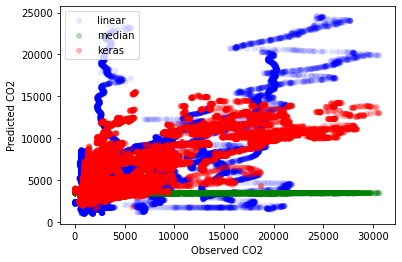

In [246]:
#Plot predictions vs observations


fig, ax = plt.subplots()

#ax.scatter(a, b, c='r', label='kNN',
 #              alpha=0.1, edgecolors='none')

#ax.scatter(a, c, c='y', label='Neural',
 #              alpha=0.1, edgecolors='none')

ax.scatter(a, d, c='b', label='linear',
               alpha=0.1, edgecolors='none')

ax.scatter(a, e, c='g', label='median',
               alpha=0.3, edgecolors='none')
ax.scatter(a, f, c='r', label='keras',
               alpha=0.3, edgecolors='none')
ax.legend(loc=2)
ax.set_xlabel('Observed CO2')
ax.set_ylabel('Predicted CO2')
plt.show()


In [247]:
import hydroeval as he


print( he.evaluator(he.nse, a, d))
print( he.evaluator(he.nse, a, e))
print( he.evaluator(he.nse, a, f))




ModuleNotFoundError: No module named 'hydroeval'

In [248]:
from sklearn.metrics import r2_score
print (r2_score(a, d))
print (r2_score(a, e))
print (r2_score(a, f))



0.2918443252463273
-0.011149621777617025
0.5170567537771134


In [106]:
len(nan_index)/len(df)

0.03137791044776119

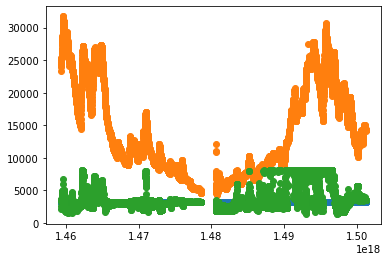

In [95]:
#Plot predictions over time
plt.scatter(nan_index.timestamp,e)
plt.scatter(nan_index.timestamp,a)
plt.scatter(nan_index.timestamp,f)


In [ ]:
df_nan